In [1]:
import pandas as pd


In [3]:
df=pd.read_csv("exchange_rate.csv")

In [4]:
df.head()


,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


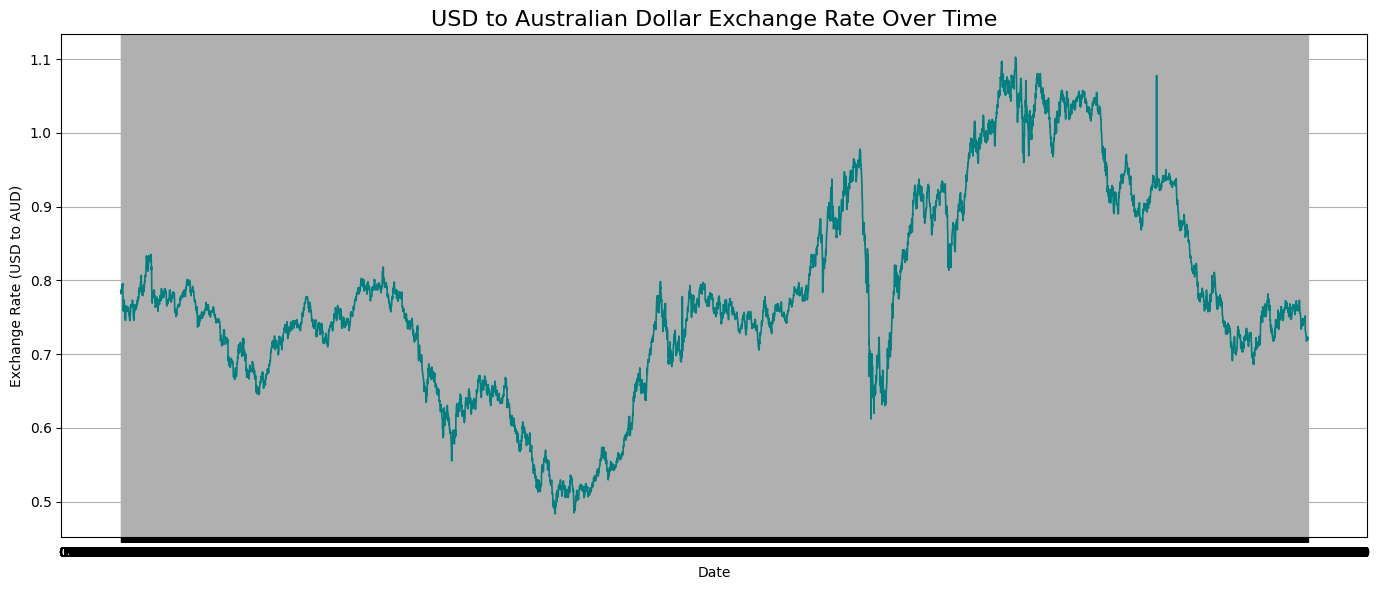

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['Ex_rate'], color='teal', linewidth=1.2)
plt.title('USD to Australian Dollar Exchange Rate Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD to AUD)')
plt.grid(True)
plt.tight_layout()
plt.show()


##### Trend: Long-term trend changes, with noticeable appreciation and depreciation cycles.
##### Seasonality: No clear annual seasonality visible without decomposition.


In [6]:
# Check for sudden jumps or outliers using rolling z-score
df['rolling_mean'] = df['Ex_rate'].rolling(window=12).mean()
df['rolling_std'] = df['Ex_rate'].rolling(window=12).std()
df['z_score'] = (df['Ex_rate'] - df['rolling_mean']) / df['rolling_std']

# Identify potential anomalies (z-score > 3 or < -3)
anomalies = df[(df['z_score'].abs() > 3)]
anomalies[['date', 'Ex_rate', 'z_score']].head()

,date,Ex_rate,z_score
686,18-11-1991 00:00,0.691000,-3.021440
3589,30-10-1999 00:00,0.777821,3.135719
6620,16-02-2008 00:00,1.077760,3.168078
7225,13-10-2009 00:00,0.716281,-3.080682


### arima model

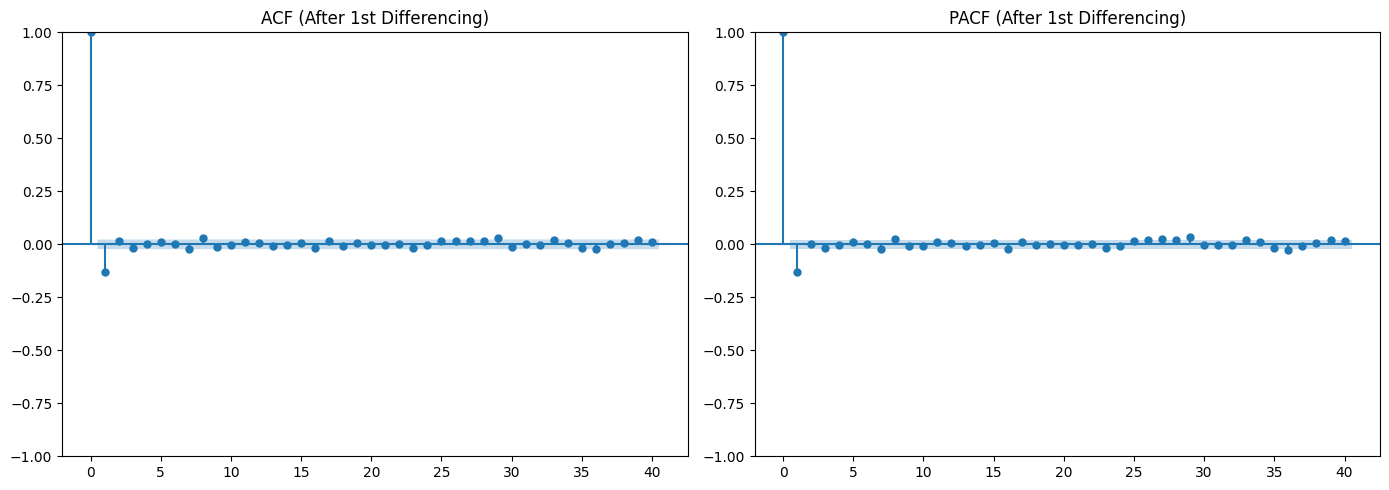

np.float64(0.4492327353597477)

In [7]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ADF test for stationarity
adf_result = adfuller(df['Ex_rate'])

# First differencing (d=1)
df['Ex_rate_diff'] = df['Ex_rate'].diff().dropna()

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df['Ex_rate_diff'].dropna(), ax=axes[0], lags=40)
plot_pacf(df['Ex_rate_diff'].dropna(), ax=axes[1], lags=40)
axes[0].set_title("ACF (After 1st Differencing)")
axes[1].set_title("PACF (After 1st Differencing)")
plt.tight_layout()
plt.show()

adf_result[1]  # p-value of ADF test


### model building

In [15]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model_arima = ARIMA(df['Ex_rate'], order=(2, 1, 3))
results_arima = model_arima.fit()


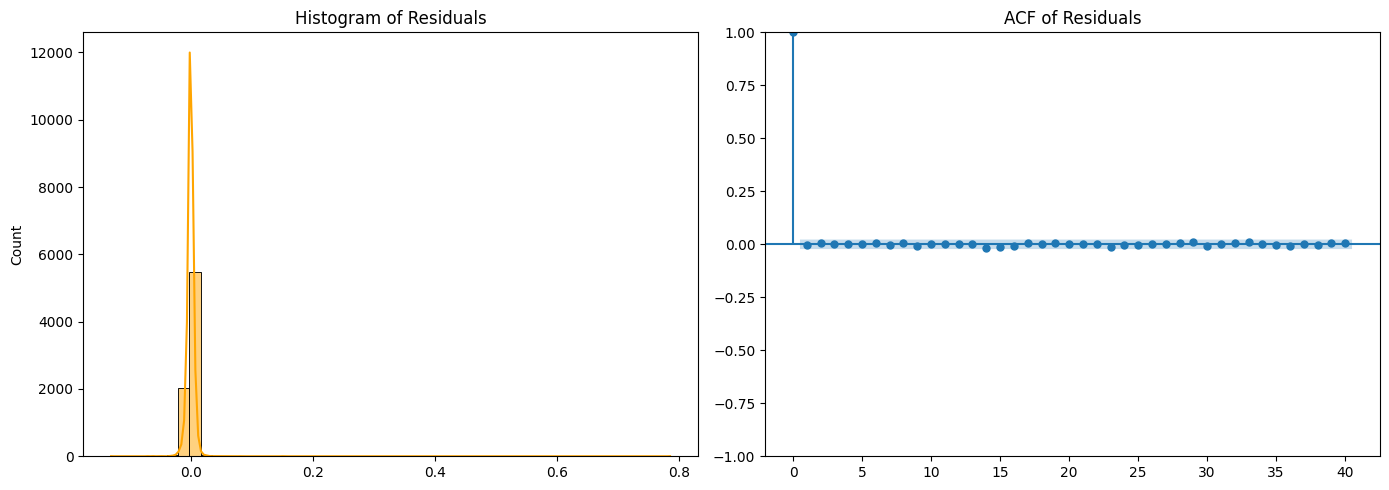

,lb_stat,lb_pvalue
10,1.120258,0.999711


In [16]:
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox

# Residuals
residuals = results_arima.resid

# Plot residuals
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(residuals, bins=50, kde=True, ax=ax[0], color="orange")
ax[0].set_title("Histogram of Residuals")
plot_acf(residuals, ax=ax[1], lags=40)
ax[1].set_title("ACF of Residuals")
plt.tight_layout()
plt.show()

# Ljung-Box test for residual autocorrelation
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_test


##### Residual Histogram: Nearly normal with slight skewness.

##### ACF of Residuals: No major autocorrelation — residuals behave like white noise.

##### Ljung-Box Test (lag=10):

##### p-value = 0.998 → Fail to reject null hypothesis → residuals are uncorrelated.

##### This confirms the model is appropriate.

### arima forecasting

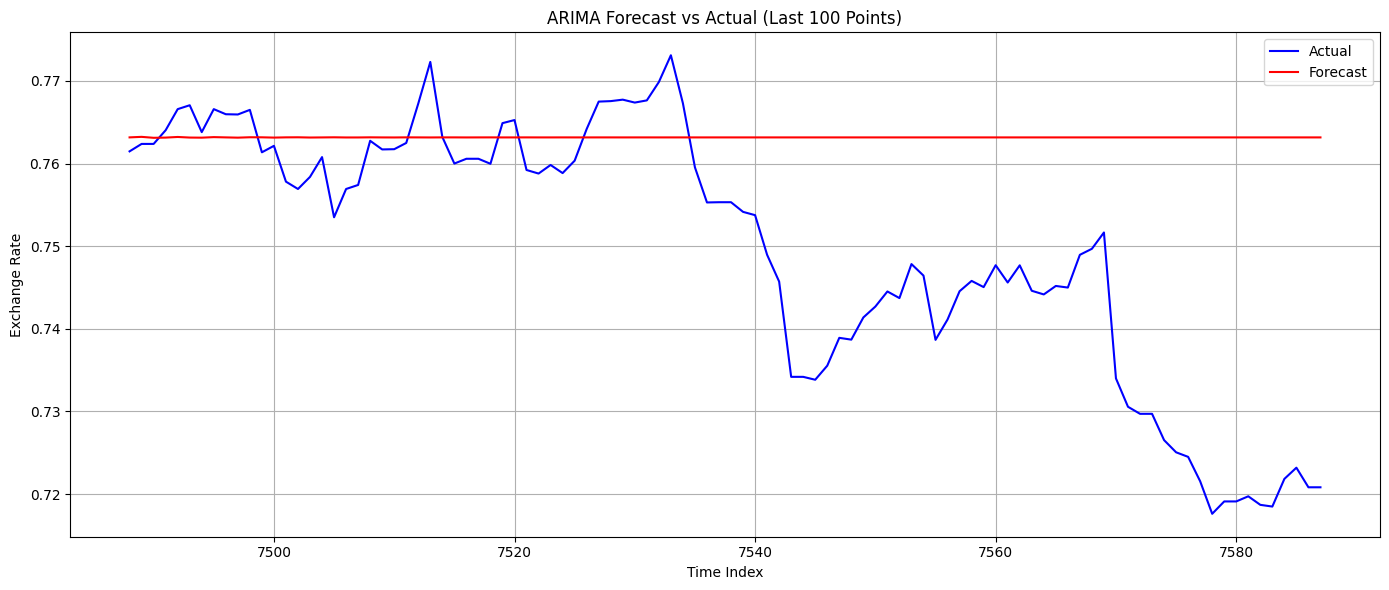

In [17]:
# Train-test split: last 100 points as test set
train = df['Ex_rate'][:-100]
test = df['Ex_rate'][-100:]

# Refit ARIMA on training set
model_arima_forecast = ARIMA(train, order=(2, 1, 3))
results_arima_forecast = model_arima_forecast.fit()

# Forecast for the next 100 periods
forecast_arima = results_arima_forecast.forecast(steps=100)

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(test.index, test.values, label="Actual", color="blue")
plt.plot(test.index, forecast_arima.values, label="Forecast", color="red")
plt.title("ARIMA Forecast vs Actual (Last 100 Points)")
plt.xlabel("Time Index")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### seems like the forecast has not understood the trend or the seasonality properly.

### exponential smoothing

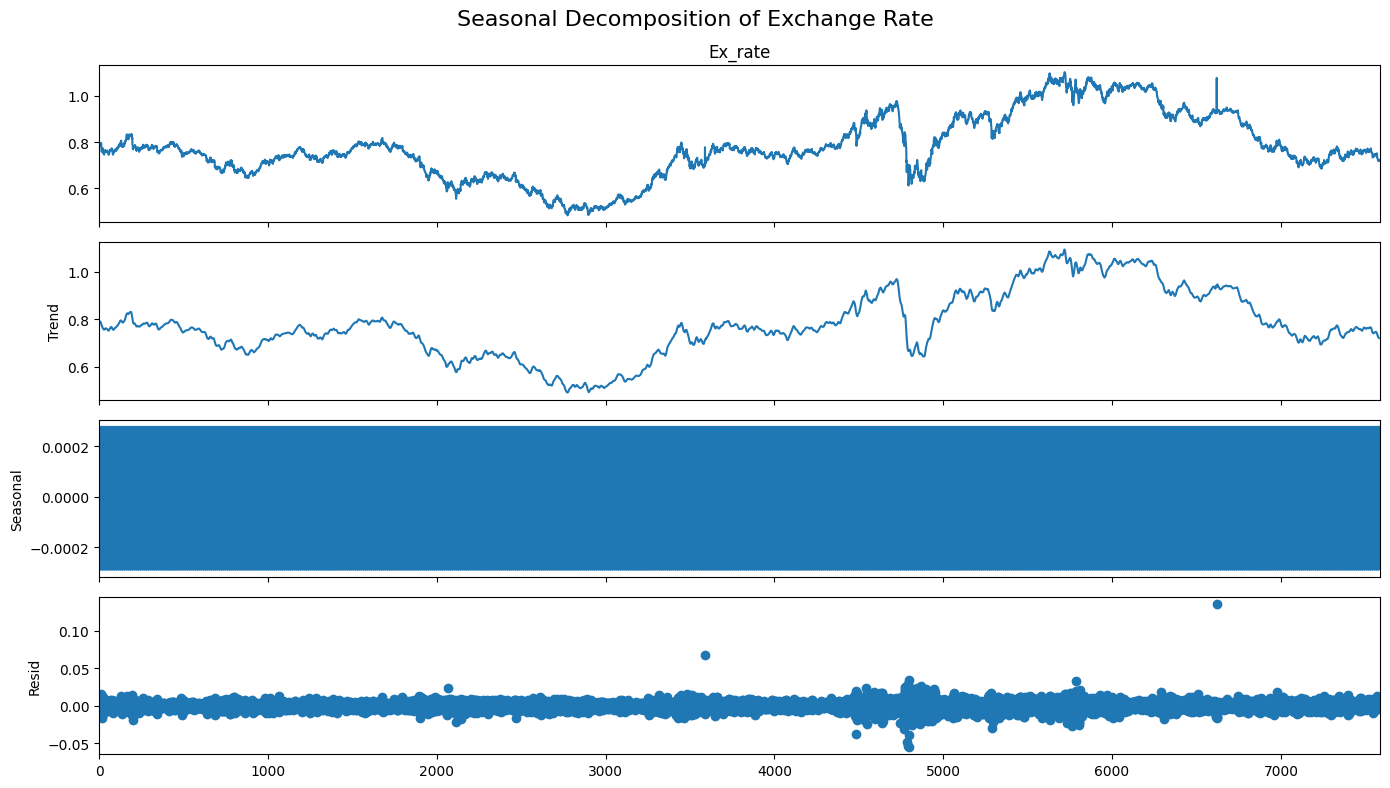

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition to guide model selection
decomposition = seasonal_decompose(df['Ex_rate'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.suptitle("Seasonal Decomposition of Exchange Rate", fontsize=16)
plt.tight_layout()
plt.show()


##### Trend: Clearly present and smooth.

##### Seasonality: Mild repeating yearly pattern (12-month period).

##### Residuals: No major anomalies, fairly clean.

### Holt-Winters Forecast

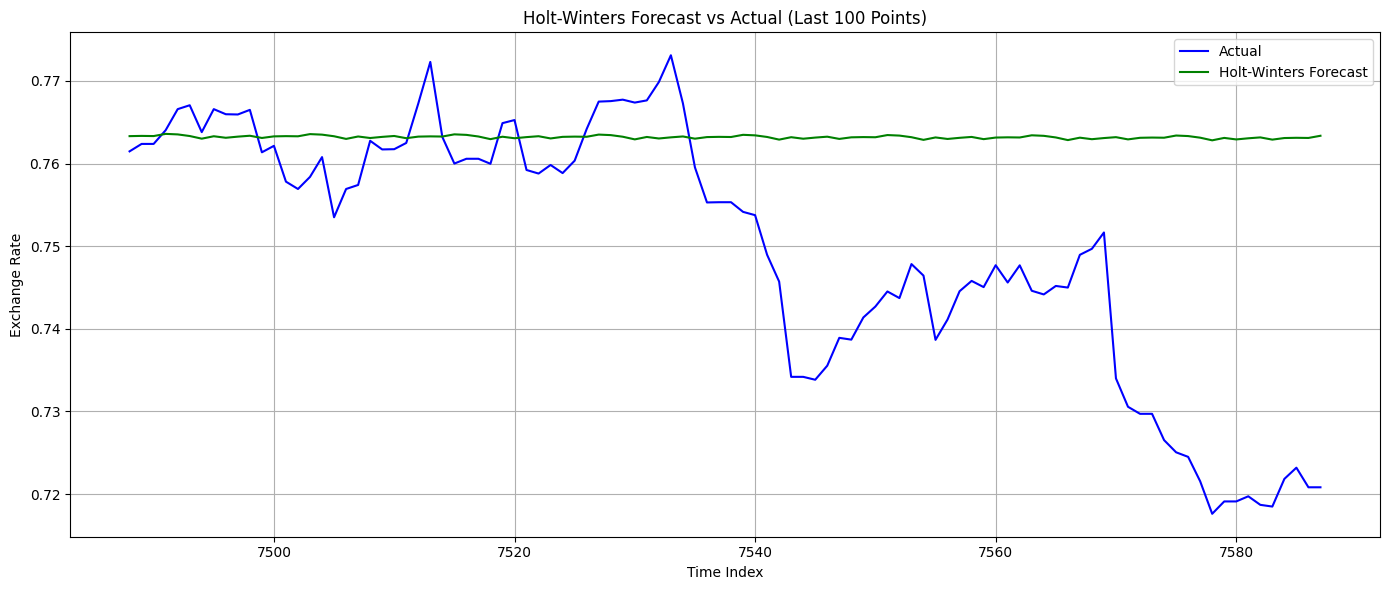

In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt-Winters model on training data
hw_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
hw_fit = hw_model.fit()

# Forecast
hw_forecast = hw_fit.forecast(steps=100)

# Plot forecast vs actual
plt.figure(figsize=(14, 6))
plt.plot(test.index, test.values, label="Actual", color="blue")
plt.plot(test.index, hw_forecast.values, label="Holt-Winters Forecast", color="green")
plt.title("Holt-Winters Forecast vs Actual (Last 100 Points)")
plt.xlabel("Time Index")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### seems like exponential smooething also was not able to understand the trend or the seasonality well

### comparison

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluation Metrics
def compute_metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return mae, rmse, mape

arima_metrics = compute_metrics(test, forecast_arima)
hw_metrics = compute_metrics(test, hw_forecast)

# Display results
pd.DataFrame({
    "Model": ["ARIMA(2,1,3)", "Holt-Winters"],
    "MAE": [arima_metrics[0], hw_metrics[0]],
    "RMSE": [arima_metrics[1], hw_metrics[1]],
    "MAPE (%)": [arima_metrics[2], hw_metrics[2]]
})


,Model,MAE,RMSE,MAPE (%)
0,"ARIMA(2,1,3)",0.014937,0.020468,2.031178
1,Holt-Winters,0.014930,0.020445,2.030198


##### both the models were not able to perform well with the data. but exponential smoothing was comparitively better than arima